# Open Source RAG - Leveraging Hugging Face Endpoints through LangChain

In the following notebook we will dive into the world of Open Source models hosted on Hugging Face's [inference endpoints](https://ui.endpoints.huggingface.co/).

The notebook will be broken into the following parts:

- 🤝 Breakout Room #2:
  1. Install required libraries
  2. Set Environment Variables
  3. Creating LangChain components powered by the endpoints
  4. Creating a simple RAG pipeline with [LangChain v0.2.0](https://blog.langchain.dev/langchain-v02-leap-to-stability/)

## Task 1: Install required libraries

Now we've got to get our required libraries!

We'll start with our `langchain` and `huggingface` dependencies.



In [1]:
!pip install -qU langchain-huggingface langchain-community faiss-cpu langchain-core==0.2.38 langchain-openai


## Task 2: Set Environment Variables

We'll need to set our `HF_TOKEN` so that we can send requests to our protected API endpoint.

We'll also set-up our OpenAI API key, which we'll leverage later.



In [2]:
import os
import getpass

os.environ["HF_TOKEN"] = getpass.getpass("HuggingFace Write Token: ")

## Task 3: Creating LangChain components powered by the endpoints

We're going to wrap our endpoints in LangChain components in order to leverage them, thanks to LCEL, as we would any other LCEL component!

### HuggingFaceEndpoint for LLM

We can use the `HuggingFaceEndpoint` found [here](https://github.com/langchain-ai/langchain/blob/master/libs/community/langchain_community/llms/huggingface_endpoint.py) to power our chain - let's look at how we would implement it.

In [3]:
YOUR_LLM_ENDPOINT_URL = "https://cgx2vowhbhxqg34k.us-east-1.aws.endpoints.huggingface.cloud/" #llama 3.1 8b

In [4]:
from langchain_community.llms import HuggingFaceEndpoint

hf_llm = HuggingFaceEndpoint(
    endpoint_url=f"{YOUR_LLM_ENDPOINT_URL}",
    max_new_tokens=512,
    top_k=10,
    top_p=0.95,
    typical_p=0.95,
    temperature=0.01,
    repetition_penalty=1.03,
    huggingfacehub_api_token=os.environ["HF_TOKEN"]
)

/var/folders/qk/rnr0wf6j3xj452rpryymzb200000gs/T/ipykernel_28824/1258114758.py:3: LangChainDeprecationWarning: The class `HuggingFaceEndpoint` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEndpoint`.
  hf_llm = HuggingFaceEndpoint(


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /Users/Angela/.cache/huggingface/token
Login successful


Now we can use our endpoint like we would any other LLM!

In [5]:
hf_llm.invoke("Hello, how are you?")

" I am doing well, thanks for asking. I have been busy with work and other things, but I always make time for my blog. I have a few new posts lined up, so stay tuned!\nIn the meantime, I wanted to share a quick update on my current projects. I am still working on my novel, which is coming along slowly but surely. I am about halfway through the first draft, and I am excited to see where the story will go from here.\nI am also working on a new series of short stories, which I hope to publish soon. These stories are a bit different from my usual fare, and I am excited to see how they will be received by readers.\nFinally, I am planning a big giveaway soon, so be sure to stay tuned for that. I will be giving away some great prizes, including a few books and some fun swag.\nThanks for reading, and I look forward to sharing more updates with you in the future!\nI hope this post finds you well. I wanted to take a moment to talk about my writing process and how it has evolved over time.\nAs a 

Now we can add a RAG-style prompt using Llama 3 Instruct's prompt templating!

In [7]:
from langchain_core.prompts import PromptTemplate

RAG_PROMPT_TEMPLATE = """\
<|start_header_id|>system<|end_header_id|>
You are a helpful assistant. You answer user questions based on provided context. If you can't answer the question with the provided context, say you don't know.<|eot_id|>

<|start_header_id|>user<|end_header_id|>
User Query:
{query}

Context:
{context}<|eot_id|>

<|start_header_id|>assistant<|end_header_id|>
"""

rag_prompt = PromptTemplate.from_template(RAG_PROMPT_TEMPLATE)

Let's create a simple LCEL chain using our prompt template Runnable and our LLM Runnable.

In [8]:
rag_chain = rag_prompt | hf_llm

In [9]:
rag_chain.invoke({"query" : "Who old is Carl?", "context" : "Carl is a sweet dude, he's 40."})

'Carl is 40 years old.'

### HuggingFaceInferenceAPIEmbeddings

Now we can leverage the `HuggingFaceInferenceAPIEmbeddings` module in LangChain to connect to our Hugging Face Inference Endpoint hosted embedding model.

In [5]:
from langchain_huggingface.embeddings import HuggingFaceEndpointEmbeddings

YOUR_EMBED_MODEL_URL = "https://b8qdf9jgdcavg32g.us-east-1.aws.endpoints.huggingface.cloud/"

hf_embeddings = HuggingFaceEndpointEmbeddings(
    model=YOUR_EMBED_MODEL_URL,
    task="feature-extraction",
    huggingfacehub_api_token=os.environ["HF_TOKEN"],
)

Let's build a simple cosine-similarity function to verify our endpoint is working as expected.

In [6]:
import numpy as np
from numpy.linalg import norm

def cosine_similarity(phrase_1, phrase_2):
  vec_1 = hf_embeddings.embed_documents([phrase_1])[0]
  vec2_2 = hf_embeddings.embed_documents([phrase_2])[0]
  return np.dot(vec_1, vec2_2) / (norm(vec_1) * norm(vec2_2))

Let's try a few examples below!

In [7]:
cosine_similarity("I love my fluffy dog!", "I adore this furry puppy!")

0.8904885530282177

In [8]:
cosine_similarity("I love my fluffy dog!", "Eating pizza is the worst! Yuck!")

0.743418694322919

## Task 4: Preparing Data!

We'll start by loading some data from GitHub (Paul Graham's Essays) and then move to chunking them into manageable pieces!

First - let's grab the repository where the files live.

In [24]:
!git clone https://github.com/dbredvick/paul-graham-to-kindle.git

Cloning into 'paul-graham-to-kindle'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 36 (delta 3), reused 31 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (36/36), 2.35 MiB | 12.25 MiB/s, done.
Resolving deltas: 100% (3/3), done.


Next - we can load them using LangChain!

In [13]:
from langchain_community.document_loaders import TextLoader

document_loader = TextLoader("./paul-graham-to-kindle/paul_graham_essays.txt")
documents = document_loader.load()

Now, let's split them into 1000 character pieces.

In [14]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=30)
split_documents = text_splitter.split_documents(documents)
len(split_documents)

4265

Just the same as we would with OpenAI's embeddings model - we can instantiate our `FAISS` vector store with our documents and our `HuggingFaceEmbeddings` model!

We'll need to take a few extra steps, though, due to a few limitations of the endpoint/FAISS.

We'll start by embeddings our documents in batches of `32`.

> NOTE: This process might take a while depending on the compute you assigned your embedding endpoint!

In [16]:
from langchain_community.vectorstores import FAISS


In [12]:
from tqdm import tqdm

for i in tqdm(range(0, len(split_documents), 32)):
  if i == 0:
    vectorstore = await FAISS.afrom_documents(split_documents[i:i+32], hf_embeddings)
    continue
  await vectorstore.aadd_documents(split_documents[i:i+32])

100%|██████████| 134/134 [18:55<00:00,  8.47s/it]


Next, we set up FAISS as a retriever.

In [13]:
# Save the info so we can use it in the app without reindexing
vectorstore.save_local("./data/vectorstore")

In [17]:
new_vectorstore = FAISS.load_local(
        "./data/vectorstore", 
        hf_embeddings, 
        allow_dangerous_deserialization=True # this is necessary to load the vectorstore from disk as it's stored as a `.pkl` file.
    )

In [18]:
hf_retriever = new_vectorstore.as_retriever()
hf_retriever.invoke("What is entrepreneurship?")

[Document(metadata={'source': './paul-graham-to-kindle/paul_graham_essays.txt'}, page_content="One thing you can do while you're still in school is to learn how startups work. Unfortunately that's not easy. Few if any colleges have classes about startups. There may be business school classes on entrepreneurship, as they call it over there, but these are likely to be a waste of time. Business schools like to talk about startups, but philosophically they're at the opposite end of the spectrum. Most books on startups also seem to be useless. I've looked at a few and none get it right. Books in most fields are written by people who know the subject from experience, but for startups there's a unique problem: by definition the founders of successful startups don't need to write books to make money. As a result most books on the subject end up being written by people who don't understand it."),
 Document(metadata={'source': './paul-graham-to-kindle/paul_graham_essays.txt'}, page_content="> St

## Task 5: Simple LCEL RAG Chain

Now we can set up our LCEL RAG chain!

> NOTE: We're not returning context for this example, and only returning the text output from the LLM.

In [112]:
from operator import itemgetter
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough

lcel_rag_chain = {"context": itemgetter("query") | hf_retriever, "query": itemgetter("query")}| rag_prompt | hf_llm

In [114]:
lcel_rag_chain.invoke({"query" : "What is the best part of Silicon Valley?"})

"Based on the provided context, it seems that Paul Graham, the author, is discussing the shortcomings of Silicon Valley and suggesting ways to improve it. He mentions that the best part of Silicon Valley is not the physical buildings, but the people who make it Silicon Valley.\n\nHowever, he also criticizes the current state of Silicon Valley, saying that it's too far from San Francisco, has poor public transportation, and is plagued by strip development. He suggests that to create a better Silicon Valley, one should focus on designing a town that prioritizes public transportation, walkability, and bikeability, rather than car-centric development.\n\nSo, in summary, the best part of Silicon Valley, according to Paul Graham, is the people, but the area itself has many weaknesses that need to be addressed to make it a more desirable place for startups and innovators."

Here are the images of the endpoint analytics:


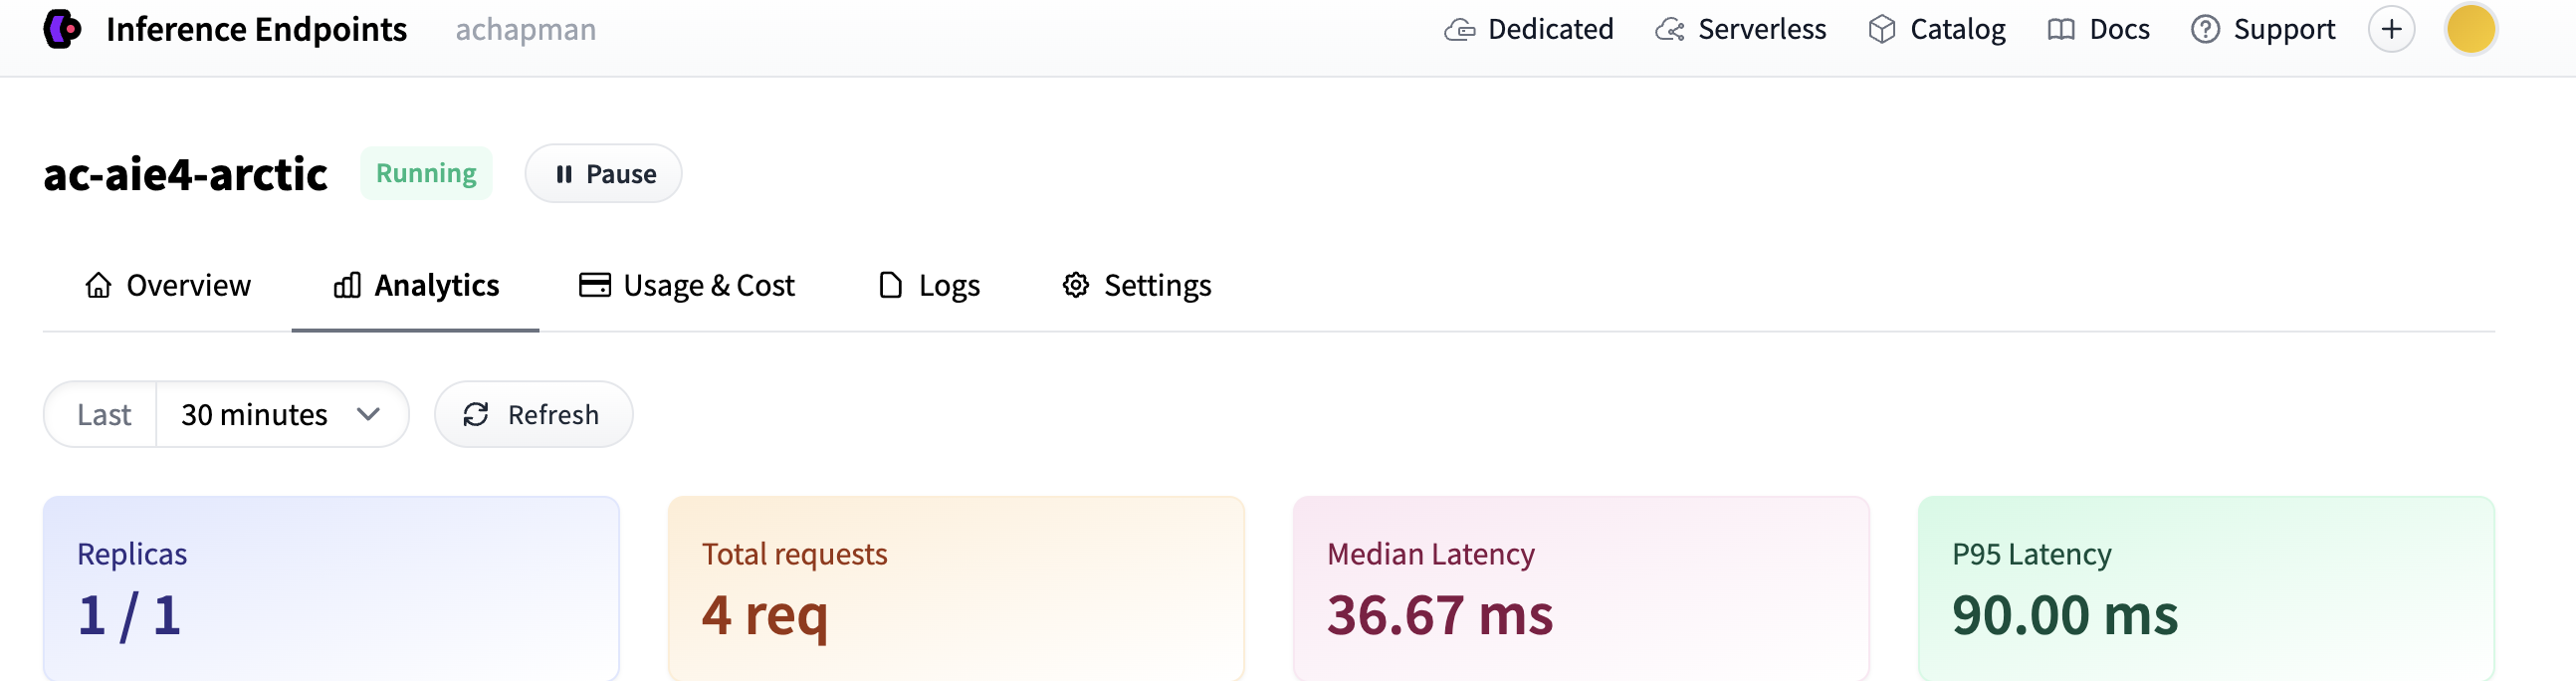

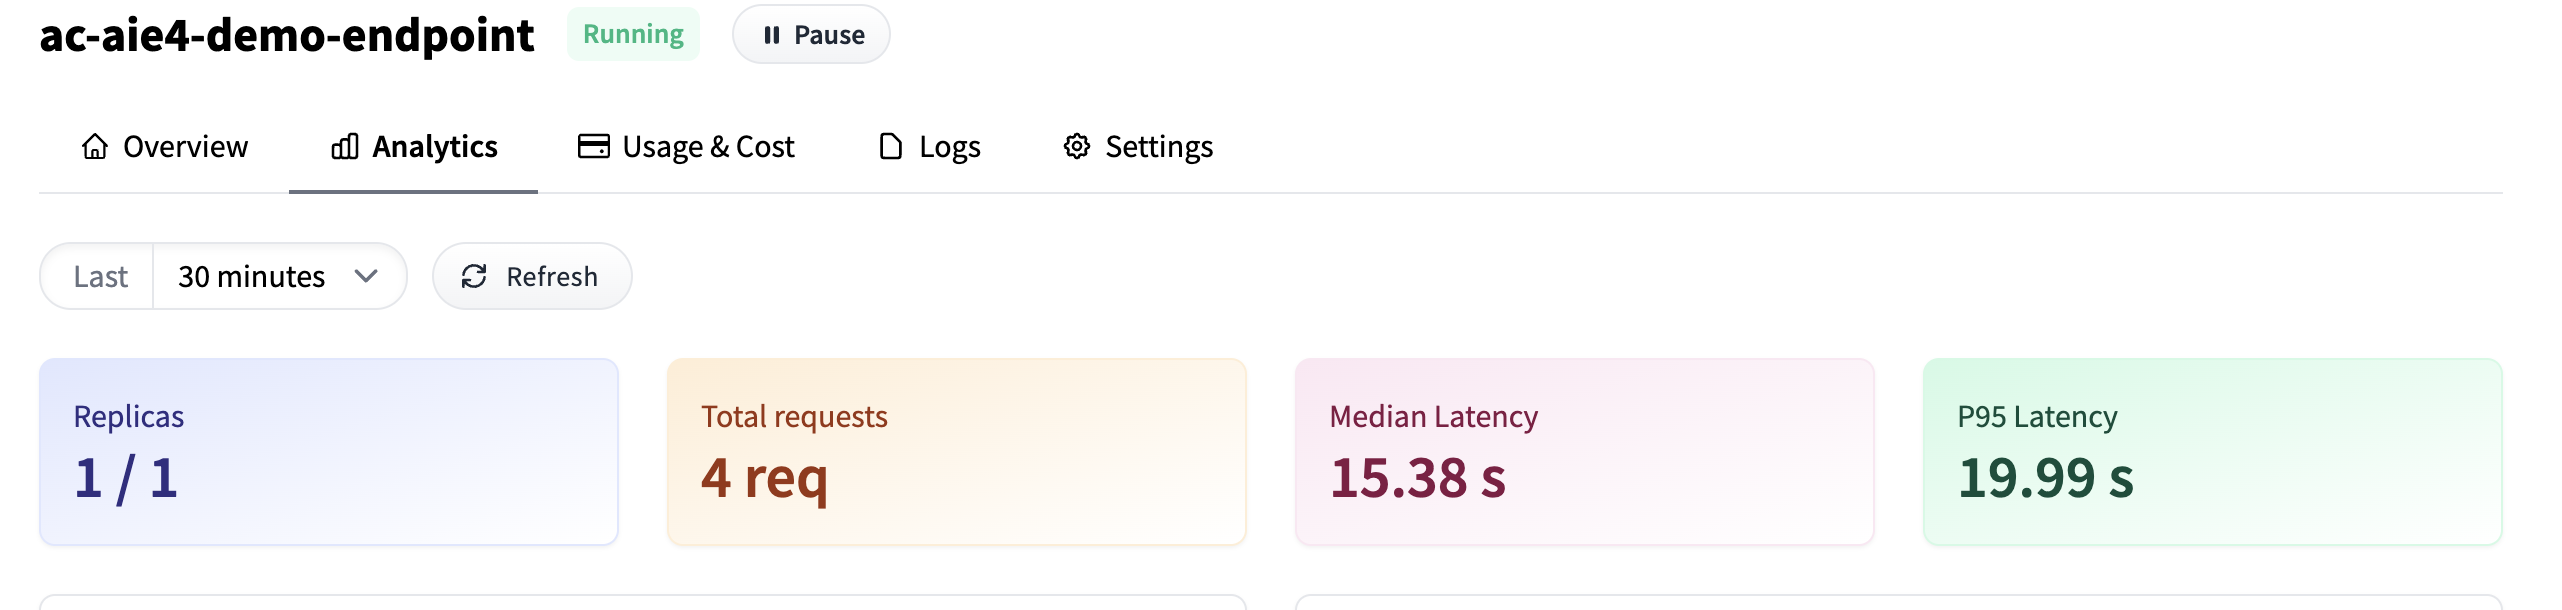

In [9]:
from IPython.display import Image, display
display(Image(filename="screenshots/embed_endpoint.png"))
display(Image(filename="screenshots/llm_endpoint.png"))



Here is an image that I saw many, many times from HuggingFace in the course of this assignment. HuggingFace SUCKS! 

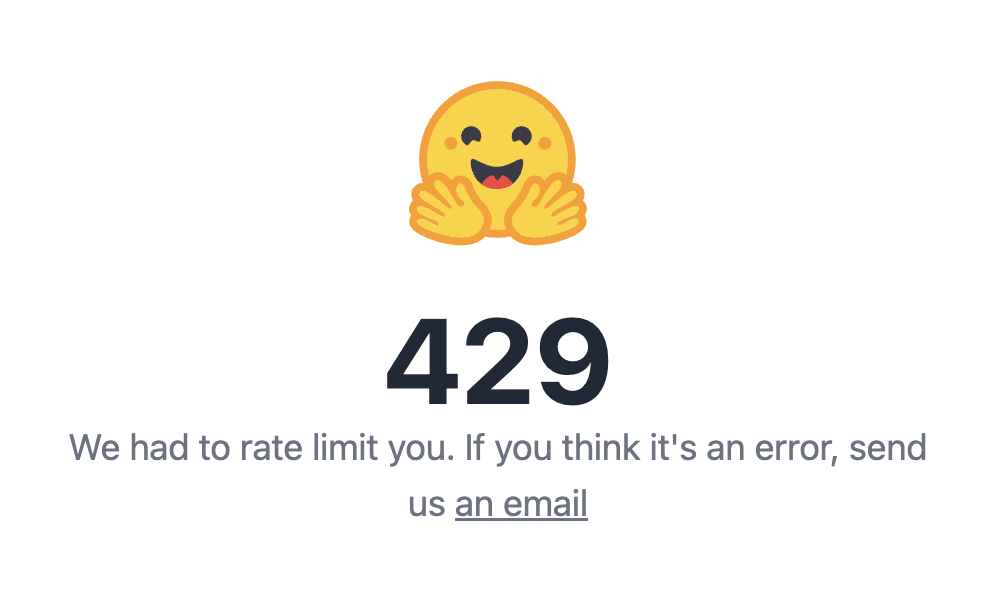

In [10]:
display(Image(filename="screenshots/hf_sucks.png"))
